<h1><center>IST 597 Foundations of Deep Learning</center></h1>

---

<h2><center>Assignment 10</center><h2>

**Instructor** : Dr. C. Lee Giles <br>
**TA** : Neisarg Dave, Shaurya Rohatgi
<br><br>

Credits: 

<h3>Course Policy<h3>

Carefully read all the instructions, before you start working on the assignment

* Give maximum explanation for each sub-problems.

* Assignments are due before class at Monday 05:59:59 pm. Please check the due date on the official course webportalg Portal.

* Please avoid single line answers, submissions without any explanations would receive 0 points.

* Late submissions will be graded with 20% discount per day. Day 1 starts immediately after the submission deadline.

* Every assignment has a hard deadline, usually 3 days past the original due date, i.e. Thursday after the due Monday

* Late submissions (penalty or not) are not accepted after the hard deadline.

* All source materials must be cited. The University Academic Code of Conduct will be strictly enforced.

* We will be creating Canvas submission page for this. Submit all files on Canvas.

* All queries related to Assignment should have a subject line *IST597:Assignment_10 Queries*

---


<h2><center>Multi Layer Perceptron</center><h2>

Multiplayer Perceptron is a feed forward neural network composed of multiple layers of affine transformations followed by non linearity function. Each layer of an MLP is defined as:
$$
z^{(l)} = W^{(l)}x^{(l-1)} + b^{(l)}
$$ 

$$
x^{(l)} = f(z^{(l)})
$$

Here, $l$ denotes the layer of MLP, $W$ and $b$ are the trainable parameters called *weight* and *bias* respectively

ReLU or Rectified Linear Unit is the most common non linear layer used with MLP.
More about ReLU can be found here: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

In this assignment you are required to do the following:

+ Create an MLP
  + Write the *forward* function for affine transformation
  + Write the *backward* function (to calculate gradients) for the affine transformation
  + Create a Neural Network by stacking these transformations

+ Train the Neural Network on Fashion MNIST Dataset
  + Write Loss Function for the training
  + Write parameter update routine
  + Run Validation 
  + Plot Train and Validation Loss Curves using Matplotlib 

+ Testing the Neural Network
  + Change the *seed* and train the neural network 10 times
  + Report the mean and variance over 10 trials on the following metrics:
    + Accuracy
    + Precision
    + Recall
    + F1
    + ROC curve

+ Change the number of parameters in the Neural Network 
  + Train a underfit model
  + Train a overfit model
  + Demostrate the difference between overfitting and underfitting


In [13]:
import torch
import random
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# select device as cuda
device = torch.device("cuda:0")

# set random seeds
seed = 1234 ## change this seed when you run trials
random.seed(seed)
torch.manual_seed(seed)

### Gradient Update
To update gradients, from the equation of affine transformation we have:

$$
z^{(l)} = W^{(l)}x^{(l-1)} + b
$$ 

We can calulate all the partial derivations in the following fashion

$$
\frac{\partial z^{(l)}}{\partial x^{(l-1)}} = W^{(l)}
$$

$$
\frac{\partial z^{(l)}}{\partial W^{(l)}} = x^{(l-1)}
$$

$$
\frac{\partial z^{(l)}}{\partial b^{(l)}} = 1
$$

To write the *backward* function, we need one more step. *backward* functon takes *grad_output* as its input. It is the backward flow of gradients coming from the final output $\hat y$ and can be mathematically expressed as:
$$
  grad\_output = \frac{\partial \hat y}{\partial z^{(l)}}
$$

*backward* functions gives out three values:

$$
grad\_x = \frac{\partial \hat y}{\partial x^{(l-1)}} = \frac{\partial \hat y}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial x^{(l-1)}} 
$$

$$
grad\_w = \frac{\partial \hat y}{\partial W^{(l)}} = \frac{\partial \hat y}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial W^{(l)}}
$$


$$
grad\_b = \frac{\partial \hat y}{\partial b^{(l)}} =  \frac{\partial \hat y}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial b^{(l)}}
$$

In the code below, update the *forward* and *backward* functions of class LinearFunction


In [14]:
class LinearFunction(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, W, b):
    """
    # x -> input matrix of size n_samples x sdim
    # W -> transformation matrix
    # b -> bias term 
    """
    ctx.save_for_backward(x, W, b)
    # Affine transformation:
    #-------------------
    # z = x. W + b
    z = torch.matmul(x, W) + b
    #-------------------
    return z
    
  @staticmethod
  def backward(ctx, grad_output):
    x, W, b = ctx.saved_tensors
   
    # Gradient updates:
    #----------------------------
    grad_x = torch.matmul(grad_output,W.T)
    grad_w = torch.matmul(grad_output.T,x).T
    grad_b = grad_output
    #-----------------------------
    return grad_x, grad_w, grad_b


Class CustomLinearLayer uses previously defined LinearFunction to create one layer of Neural Network. Look at the initial values given to $W$ and $b$.
You do not need to change anything in this class.

In [15]:
class CustomLinearLayer(torch.nn.Module):
  def __init__(self, in_features, out_features):
    super(CustomLinearLayer, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    w = torch.normal(mean = 0, std = 0.1, size = [in_features, out_features], requires_grad=True)
    b = torch.full([out_features], 0.01, requires_grad=True)
    w = torch.nn.Parameter(w)
    b = torch.nn.Parameter(b)
    self.register_parameter('w', w)
    self.register_parameter('b', b)
    self.linear_function = LinearFunction.apply
  
  def forward(self, x):
    return self.linear_function(x, self.w, self.b)

In the Neural Network class below class Below, Add two linear layers of the following sizes:
+ 784 x 512
+ 512 x 10

In the forward function, 
+ Apply layer_1 on input
+ Apply activation function on the result
+ Apply layer_2 on the result
+ Apply Softmax and return the final result

In [16]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    # Add Linear layers below with the given dimensions
    #-----------------------------------
    self.layer_1 = CustomLinearLayer(784, 512)
    self.layer_2 = CustomLinearLayer(512, 10)
    # ------------------------------------
    self.activation = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=-1)
  
  def forward(self, x):
    # Applying layers defined above:
    #-------------------------------
    output_1 = self.layer_1(x)
    output_1_actv = self.activation(output_1)
    output_2 = self.layer_2(output_1_actv)
    output = self.softmax(output_2)
    #-------------------------------
    return output

Fasion MNIST dataset is a set of grayscale images categorized into 10 classes. To train our neural network, first we need to define loss function. $y$ is the ground truth class label and $probs$ is the probability distribution given by our Neural Network over 10 classes, update the *forward* function of loss class below. 

$$
ce\_loss = -\frac{1}{{\#samples}}\sum^{\#samples}_i y_i.\log(probs_i)
$$

*Hint*: Try representing $y$ as one hot vector

In [17]:
class CrossEntropyLoss(torch.nn.Module):
  def __init__(self):
    super(CrossEntropyLoss, self).__init__()
  
  def forward(self, probs, y):
    #Loss function here:
    #-------------------------------
    loss = -1 * torch.mean(torch.sum(torch.nn.functional.one_hot(y, num_classes= 10) * torch.log(probs),axis=1))
    #-------------------------------
    return loss

In [18]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

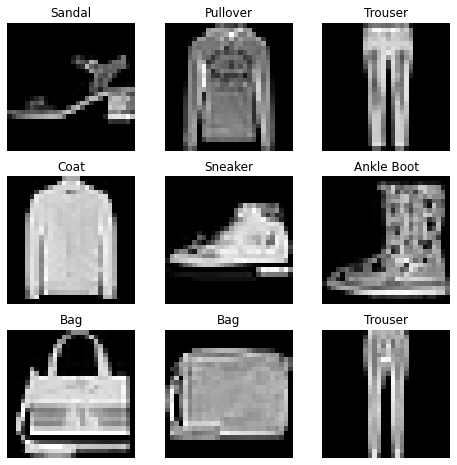

In [19]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Fashion MNIST dataset loaded from pytorch APIs only has two sets: train and test. Split the train data into train and validation sets with 50K samples in train and 10K samples in validation set. The data split should be random.

*Hint* Look for a function in *torch.utils.data*

In [20]:
# split random mnist trainset into two sets: mnist trainset -> 50000 , mnist validation set -> 10000
#----------------
train_data, val_data = torch.utils.data.random_split(training_data,[50000, 10000])
#----------------

In [21]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [22]:
model = NeuralNetwork().cuda()
ce_loss = CrossEntropyLoss()

1) The gradients we calculated in the start can be accessed by iterating over model.parameters() as *params.grad*. Write the parameter update rule in the training code below: 

$$
param := param - learning\_rate*gradient
$$

2) Write validation loop which runs every epoch and prints the following metrics on validation set:
  + Accuracy
  + Precision
  + Recall
  + F1 
  + roc_auc

3) Store the training loss and validation loss in each iteration and plot a graph comparing them.

Epoch 0/10 Iteration 0/49 Loss 3.6421902179718018: 
Epoch 0/10 Iteration 1/49 Loss 2.8335654735565186: 
Epoch 0/10 Iteration 2/49 Loss 2.489055633544922: 
Epoch 0/10 Iteration 3/49 Loss 2.36944580078125: 
Epoch 0/10 Iteration 4/49 Loss 2.2263412475585938: 
Epoch 0/10 Iteration 5/49 Loss 2.039961814880371: 
Epoch 0/10 Iteration 6/49 Loss 1.96735417842865: 
Epoch 0/10 Iteration 7/49 Loss 1.9270508289337158: 
Epoch 0/10 Iteration 8/49 Loss 1.909238338470459: 
Epoch 0/10 Iteration 9/49 Loss 1.829696536064148: 
Epoch 0/10 Iteration 10/49 Loss 1.736072301864624: 
Epoch 0/10 Iteration 11/49 Loss 1.6891040802001953: 
Epoch 0/10 Iteration 12/49 Loss 1.6831845045089722: 
Epoch 0/10 Iteration 13/49 Loss 1.6354825496673584: 
Epoch 0/10 Iteration 14/49 Loss 1.6609686613082886: 
Epoch 0/10 Iteration 15/49 Loss 1.546505331993103: 
Epoch 0/10 Iteration 16/49 Loss 1.5746090412139893: 
Epoch 0/10 Iteration 17/49 Loss 1.5222102403640747: 
Epoch 0/10 Iteration 18/49 Loss 1.5270293951034546: 
Epoch 0/10 It

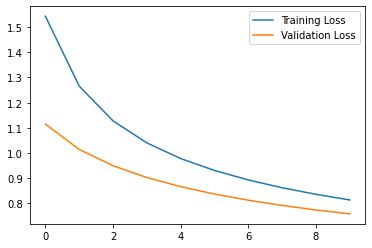

In [11]:
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report,roc_auc_score,f1_score,precision_score,recall_score

batch_size = 1024
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
valid_loader = DataLoader(val_data, batch_size=batch_size)
max_epochs = 10
learning_rate = 0.01
train_iter_loss = []
valid_iter_loss = []
training_loss = []
validation_loss = []

for epoch in range(max_epochs):
  for idx, data in enumerate(train_loader):
    features, labels = data

    features = features.cuda()

    labels = labels.cuda()
    probs = model(features.reshape([-1, 784]))

    loss = ce_loss(probs, labels)
    train_iter_loss.append(loss.item())
    print("Epoch {0}/{1} Iteration {2}/{3} Loss {4}: ".format(epoch, max_epochs, idx, len(train_loader), loss))
    
    for param in model.parameters():
      param.grad = None
      
    loss.backward()

    for name, param in model.named_parameters():
      # Parameter update routine:
      # --------------
      new_param = param - learning_rate * param.grad
      
      # --------------
      with torch.no_grad():
        param.copy_(new_param)
  # Taking the mean of training loss in each iteration
  training_loss.append(torch.mean(torch.Tensor(train_iter_loss)))

  # Variable initialization for each epoch
  total = 0
  accuracy_total = 0
  recall_total = []
  precision_total = []
  f1_total = []
  roc_auc_total = []

  # Validation routine here: 
  #----------------------------
  for idx, valid_data in enumerate(valid_loader):
    features, labels = valid_data
    features = features.cuda()
    labels = labels.cuda()
    
    with torch.no_grad():
      probs = model(features.reshape([-1, 784]))
      max_prob  = torch.argmax(probs, dim=1)
      loss = ce_loss(probs, labels)
      # Validation loss in each iteration will be whole iteration
      valid_iter_loss.append(loss.item())

      # The expected class for the given input 
      y_true = labels.cpu().numpy() 
      # The predicted class for the given input 
      y_pred = probs.argmax(axis=1).cpu().numpy()
      # The predicted class score for the given input 
      y_score = probs.cpu().detach().numpy()
      
      # Calculation of the metrics for the validation set
      precision = precision_score(y_true, y_pred,average ='macro')
      recall = recall_score(y_true, y_pred, average ='macro')
      f1 = f1_score(y_true, y_pred,average = 'macro')
      roc_auc = roc_auc_score(y_true, y_score,multi_class='ovr')
      
      accuracy_total+= sum(labels==max_prob).item()
      total +=labels.shape[0]

      recall_total.append(recall)
      precision_total.append(precision)
      f1_total.append(f1)
      roc_auc_total.append(roc_auc)

  validation_loss.append(torch.mean(torch.Tensor(valid_iter_loss)))
  accuracy = accuracy_total/total
  recall_mean = sum(recall_total)/len(recall_total)
  precision_mean = sum(precision_total)/len(precision_total)
  f1_mean = sum(f1_total)/len(f1_total)
  roc_auc_mean = sum(roc_auc_total)/len(roc_auc_total)
  
  print("Validation Epoch {0}/{1} Iteration {2}/{3} accuracy {4}: ".format(epoch, max_epochs, idx, len(valid_loader), accuracy))
  print("Validation Epoch {0}/{1} Iteration {2}/{3} recall_mean {4}: ".format(epoch, max_epochs, idx, len(valid_loader), recall_mean))
  print("Validation Epoch {0}/{1} Iteration {2}/{3} precision_mean {4}: ".format(epoch, max_epochs, idx, len(valid_loader), precision_mean))
  print("Validation Epoch {0}/{1} Iteration {2}/{3} f1_mean {4}: ".format(epoch, max_epochs, idx, len(valid_loader), f1_mean))
  print("Validation Epoch {0}/{1} Iteration {2}/{3} roc_auc_mean {4}: ".format(epoch, max_epochs, idx, len(valid_loader), roc_auc_mean))
  print("\n")


plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.show()

Testing the Neural Network
  + Change the *seed* and train the neural network 10 times
  + Report the mean and variance over 10 trials on the following metrics:
    + Accuracy
    + Precision
    + Recall
    + F1
    + ROC curve



In [12]:
## Write Relevant training and reporting code here:
#----------------------------------------------------
import random
from sklearn.metrics import roc_curve
import numpy as np

accuracies = []
precisions = []
recalls = []
f1s = []
rocs = []

for i in range(10):
  seed = random.randrange(150, 700)
  random.seed(seed)
  torch.manual_seed(seed)

  model = NeuralNetwork().cuda()


  for epoch in range(max_epochs):
    for idx, data in enumerate(train_loader):
      features, labels = data

      features = features.cuda()
      labels = labels.cuda()

      probs = model(features.reshape([-1, 784]))

      loss = ce_loss(probs, labels)
      training_loss.append(loss.item())

      for param in model.parameters():
        param.grad = None

      loss.backward()

      for name, param in model.named_parameters():
        new_param = param - learning_rate * param.grad
        
        with torch.no_grad():
          param.copy_(new_param)
    
  accuracy_total = 0
  total = 0

  recall_total = []
  precision_total = []
  f1_total = []
  roc_auc_total = []

  for idx, data in enumerate(test_loader):
    features, labels = data

    features = features.cuda()
    labels = labels.cuda()

    with torch.no_grad():
      probs = model(features.reshape([-1, 784]))

      loss = ce_loss(probs, labels)
      validation_loss.append(loss.item())

      max_prob = torch.argmax(probs, dim=1)

      accuracy_total += sum(max_prob == labels).item()
      total += labels.shape[0]
      y_true = labels.cpu().numpy()
      y_pred = probs.argmax(axis=1).cpu().numpy()
      y_score = probs.cpu().detach().numpy()
      
      precision = precision_score(y_true, y_pred,average ='macro')
      recall = recall_score(y_true, y_pred, average ='macro')
      f1 = f1_score(y_true, y_pred,average = 'macro')
      roc_auc = roc_auc_score(y_true, y_score,multi_class='ovr')

    recall_total.append(recall)
    precision_total.append(precision)
    f1_total.append(f1)
    roc_auc_total.append(roc_auc)

  accuracy = accuracy_total/total

  accuracies.append(accuracy)
  precisions.append(sum(precision_total)/len(precision_total))
  recalls.append(sum(recall_total)/len(recall_total))
  f1s.append(sum(f1_total)/len(f1_total))
  rocs.append(sum(roc_auc_total)/len(roc_auc_total))

  print(f"seed = {seed} | accuracy={accuracy}, precision={precision}, recall={recall}, f1={f1}, roc_auc={roc_auc}")
  print("")

print(f"\nAccuracy-> Mean: {sum(accuracies)/len(accuracies)}, Variance: {np.var(accuracies)}")
print(f"Precision-> Mean: {sum(precisions)/len(precisions)}, Variance: {np.var(precisions)}")
print(f"Recall-> Mean: {sum(recalls)/len(recalls)}, Variance: {np.var(recalls)}")
print(f"F1-> Mean: {sum(f1s)/len(f1s)}, Variance: {np.var(f1s)}")
print(f"ROC-> Mean: {sum(rocs)/len(rocs)}, Variance: {np.var(rocs)}")

seed = 601 | accuracy=0.7838, precision=0.7907998230898294, recall=0.7919437355826745, f1=0.7878292667090396, roc_auc=0.9723935777139723

seed = 347 | accuracy=0.7829, precision=0.7796870568679034, recall=0.7827882328525836, f1=0.7781365542692459, roc_auc=0.9719816133170311

seed = 508 | accuracy=0.7901, precision=0.7911002025172534, recall=0.7940156506058414, f1=0.7911637901244217, roc_auc=0.9737642894103086

seed = 579 | accuracy=0.7865, precision=0.790436921567204, recall=0.7905809839261172, f1=0.7889180656859652, roc_auc=0.9739233278893451

seed = 473 | accuracy=0.7857, precision=0.783939693647038, recall=0.7869658583772564, f1=0.7842724798421433, roc_auc=0.9713335230215258

seed = 494 | accuracy=0.7824, precision=0.7792968895136851, recall=0.7859250450804995, f1=0.7807007517016054, roc_auc=0.9711918149663175

seed = 303 | accuracy=0.7803, precision=0.7837314788673485, recall=0.7829731277435733, f1=0.7824070309172954, roc_auc=0.9718236685479497

seed = 182 | accuracy=0.7832, precis

+ Change the number of parameters in the Neural Network 
  + Train an underfit model
  + Train a overfit model
  + Demostrate the difference between overfitting and underfitting. Give detailed reasoning.

Epoch 0/21 Iteration 0/49 Loss 5.198268890380859: 
Epoch 0/21 Iteration 1/49 Loss 3.698981285095215: 
Epoch 0/21 Iteration 2/49 Loss 2.8212122917175293: 
Epoch 0/21 Iteration 3/49 Loss 2.241880178451538: 
Epoch 0/21 Iteration 4/49 Loss 2.03098201751709: 
Epoch 0/21 Iteration 5/49 Loss 1.9312150478363037: 
Epoch 0/21 Iteration 6/49 Loss 1.8193764686584473: 
Epoch 0/21 Iteration 7/49 Loss 1.7383151054382324: 
Epoch 0/21 Iteration 8/49 Loss 1.6587705612182617: 
Epoch 0/21 Iteration 9/49 Loss 1.6116873025894165: 
Epoch 0/21 Iteration 10/49 Loss 1.5005861520767212: 
Epoch 0/21 Iteration 11/49 Loss 1.4743459224700928: 
Epoch 0/21 Iteration 12/49 Loss 1.4294978380203247: 
Epoch 0/21 Iteration 13/49 Loss 1.4062213897705078: 
Epoch 0/21 Iteration 14/49 Loss 1.3547742366790771: 
Epoch 0/21 Iteration 15/49 Loss 1.2816632986068726: 
Epoch 0/21 Iteration 16/49 Loss 1.3524682521820068: 
Epoch 0/21 Iteration 17/49 Loss 1.2516263723373413: 
Epoch 0/21 Iteration 18/49 Loss 1.2652673721313477: 
Epoch 0/

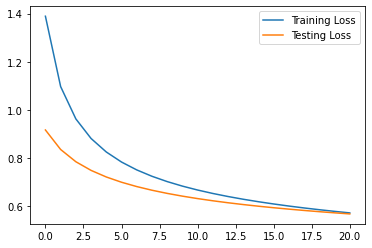

In [29]:
## Create new models here with different number of parameters, discuss and demonstrate underfitting and overfitting in NN
#----------------------------------------------------
from torch.utils.data import DataLoader
batch_size = 1024
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
class OverFittingModel(torch.nn.Module):
  def __init__(self):
    super(OverFittingModel, self).__init__()
    # Adding 4 layers for overfitting
    self.layer_1 = CustomLinearLayer(784, 512)
    self.layer_2 = CustomLinearLayer(512, 400)
    self.layer_3 = CustomLinearLayer(400, 150)
    self.layer_4 = CustomLinearLayer(150, 10)
    self.activation = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=-1)
  
  def forward(self, x):
    output_1 = self.layer_1(x)
    output_1_actv = self.activation(output_1)
    output_2 = self.layer_2(output_1_actv)
    output_2_actv = self.activation(output_2)
    output_3 = self.layer_3(output_2_actv)
    output_3_actv = self.activation(output_3)
    output_4 = self.layer_4(output_3_actv)
    output = self.softmax(output_4)
    return output
  
modelOverFitting = OverFittingModel().cuda()
ce_loss = CrossEntropyLoss()

train_iter_loss =[]
test_iter_loss = []
training_loss = []
testing_loss = []
max_epochs = 21
learning_rate = 0.01


for epoch in range(max_epochs):
  for idx, data in enumerate(train_loader):
    features, labels = data
    features = features.cuda()

    labels = labels.cuda()
    probs = modelOverFitting(features.reshape([-1, 784]))

    loss = ce_loss(probs, labels)
    train_iter_loss.append(loss.item())
    print("Epoch {0}/{1} Iteration {2}/{3} Loss {4}: ".format(epoch, max_epochs, idx, len(train_loader), loss))
    
    for param in modelOverFitting.parameters():
      param.grad = None
      
    loss.backward()

    for name, param in modelOverFitting.named_parameters():
      # Write paramtere update routine here:
      # --------------
      new_param = param - learning_rate * param.grad
      
      # --------------
      with torch.no_grad():
        param.copy_(new_param)
  training_loss.append(torch.mean(torch.Tensor(train_iter_loss)))

  total = 0
  accuracy_total = 0
  recall_total = []
  precision_total = []
  f1_total = []
  roc_auc_total = []

  # Write Testing routine here: 
  #----------------------------
  for idx, data in enumerate(test_loader):
    features, labels = data
    features = features.cuda()
    labels = labels.cuda()
    
    with torch.no_grad():
      probs = modelOverFitting(features.reshape([-1, 784]))
      loss = ce_loss(probs, labels)
      test_iter_loss.append(loss.item())

  testing_loss.append(torch.mean(torch.Tensor(test_iter_loss)))
plt.plot(training_loss, label='Training Loss')
plt.plot(testing_loss, label='Testing Loss')
plt.legend()
plt.show()

Epoch 0/5 Iteration 0/49 Loss 2.685854434967041: 
Epoch 0/5 Iteration 1/49 Loss 2.5753092765808105: 
Epoch 0/5 Iteration 2/49 Loss 2.5097265243530273: 
Epoch 0/5 Iteration 3/49 Loss 2.472240447998047: 
Epoch 0/5 Iteration 4/49 Loss 2.4664745330810547: 
Epoch 0/5 Iteration 5/49 Loss 2.432116985321045: 
Epoch 0/5 Iteration 6/49 Loss 2.40918231010437: 
Epoch 0/5 Iteration 7/49 Loss 2.363949775695801: 
Epoch 0/5 Iteration 8/49 Loss 2.2961232662200928: 
Epoch 0/5 Iteration 9/49 Loss 2.307851552963257: 
Epoch 0/5 Iteration 10/49 Loss 2.3118553161621094: 
Epoch 0/5 Iteration 11/49 Loss 2.25954008102417: 
Epoch 0/5 Iteration 12/49 Loss 2.250519275665283: 
Epoch 0/5 Iteration 13/49 Loss 2.2687673568725586: 
Epoch 0/5 Iteration 14/49 Loss 2.2444419860839844: 
Epoch 0/5 Iteration 15/49 Loss 2.193808078765869: 
Epoch 0/5 Iteration 16/49 Loss 2.1962947845458984: 
Epoch 0/5 Iteration 17/49 Loss 2.183842897415161: 
Epoch 0/5 Iteration 18/49 Loss 2.1745553016662598: 
Epoch 0/5 Iteration 19/49 Loss 2.1

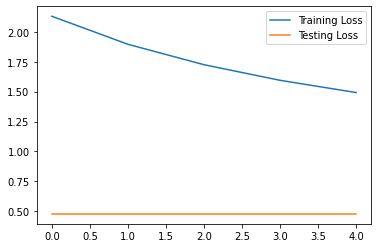

In [31]:
## Create new models here with different number of parameters, discuss and demonstrate underfitting and overfitting in NN
#----------------------------------------------------
from torch.utils.data import DataLoader
batch_size = 1024
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
class UnderFittingModel(torch.nn.Module):
  def __init__(self):
    super(UnderFittingModel, self).__init__()
    # Manipulaing 2 layers for underfitting but reducing the number of nodes
    self.layer_1 = CustomLinearLayer(784, 80)
    self.layer_2 = CustomLinearLayer(80, 10)
    self.activation = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=-1)
  
  def forward(self, x):
    output_1 = self.layer_1(x)
    output_1_actv = self.activation(output_1)
    output_2 = self.layer_2(output_1_actv)
    output = self.softmax(output_2)
    return output
  
modelUnderFitting = UnderFittingModel().cuda()
ce_loss = CrossEntropyLoss()

train_iter_loss =[]
test_iter_loss = []
training_loss = []
testing_loss = []
# Reducing the number of epoch for the training
max_epochs = 5
learning_rate = 0.01


for epoch in range(max_epochs):
  for idx, data in enumerate(train_loader):
    features, labels = data
    features = features.cuda()

    labels = labels.cuda()
    probs = modelUnderFitting(features.reshape([-1, 784]))

    loss = ce_loss(probs, labels)
    train_iter_loss.append(loss.item())
    print("Epoch {0}/{1} Iteration {2}/{3} Loss {4}: ".format(epoch, max_epochs, idx, len(train_loader), loss))
    
    for param in modelUnderFitting.parameters():
      param.grad = None
      
    loss.backward()

    for name, param in modelUnderFitting.named_parameters():
      # Write paramtere update routine here:
      # --------------
      new_param = param - learning_rate * param.grad
      
      # --------------
      with torch.no_grad():
        param.copy_(new_param)
  training_loss.append(torch.mean(torch.Tensor(train_iter_loss)))

  total = 0
  accuracy_total = 0
  recall_total = []
  precision_total = []
  f1_total = []
  roc_auc_total = []

  # Write Testing routine here: 
  #----------------------------
  for idx, data in enumerate(test_loader):
    features, labels = data
    features = features.cuda()
    labels = labels.cuda()
    
    with torch.no_grad():
      probs = modelOverFitting(features.reshape([-1, 784]))
      loss = ce_loss(probs, labels)
      test_iter_loss.append(loss.item())

  testing_loss.append(torch.mean(torch.Tensor(test_iter_loss)))
plt.plot(training_loss, label='Training Loss')
plt.plot(testing_loss, label='Testing Loss')
plt.legend()
plt.show()

It is possible to identify overfitting by comparing the training loss to the testing loss. If the training loss is smaller than the testing loss, it can be assumed that the model has to overfit the training data and is not properly generalizing to new data. On the other hand, if both the training loss and the testing loss are higher than the equivalent values for a benchmark model, then suggests that the model is underfitting and has not been successful in learning the underlying patterns in the data.
An study of the training loss and testing loss can be used to determine whether a model is overfitting or underfitting. The model has a high degree of fit to the training data, but is not generalizing well to new, unseen data, it can be concluded if the training loss is determined to be smaller than the testing loss. Overfitting is indicated by the given. On the other hand, if the training loss and testing loss are both higher than the comparable figures for a benchmark model, then indicates that the model is underfitting and is not effectively capturing the underlying patterns in the data.



